In [26]:
import pyreadr
import math
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import datetime
import matplotlib.pyplot as plt

In [2]:
# Read csv of ETF log return and Fama French Data
etf_ff_data = pd.read_csv('/Users/Ravi/Desktop/FE 630/FE-630-Final-Project/ETF_ff_Data.csv')
# Format Date column properly
etf_ff_data = etf_ff_data.rename(columns = {"Unnamed: 0":"Date"})
etf_ff_data["Date"] = pd.to_datetime(etf_ff_data["Date"])

# Print first 5 rows
print(etf_ff_data.head())

        Date       FXE       EWJ       GLD       QQQ       SPY       SHV  \
0 2007-03-01 -0.839828 -1.195132 -2.501816 -1.163088 -0.751041 -0.006970   
1 2007-03-02  0.171981 -4.117049 -8.078399 -3.797862 -3.299941  0.138968   
2 2007-03-05 -1.909022 -3.662292 -3.085226 -1.957486 -2.398792 -0.046303   
3 2007-03-06  0.673292  6.016801  4.885436  4.184908  4.311590  0.023115   
4 2007-03-07  1.112738 -0.518451  0.589248 -0.999778 -0.252521  0.092518   

        DBA       USO       XBI        ILF        EPP       FEZ  Mkt.RF   SMB  \
0 -3.359973  0.295435 -4.080605  -2.704520  -4.252163 -3.696786   -0.25 -0.11   
1 -2.364891 -1.131163 -6.168434  -5.192701  -2.743254 -3.324511   -1.24 -0.64   
2 -0.477437 -6.866887 -2.234872  -5.769796  -7.753573 -4.524134   -1.11 -0.69   
3 -1.339417  3.555023  3.079937  12.416449  10.339075  7.155172    1.58  0.65   
4  2.308413  4.857716 -0.978065  -2.114237  -0.862710 -0.476527   -0.21 -0.09   

    HML     RF  
0  0.15  0.019  
1  0.26  0.019  
2 -0.

In [109]:
def calculate_params(etf_ff_data = etf_ff_data, start = '2007-03-01', end = '2022-10-31'):
    # Subsetting data into start and end timeframe
    etf_ff_data = etf_ff_data[(etf_ff_data['Date'] >= start) & (etf_ff_data['Date'] <= end)]
    # Calculating Mkt from Fama French Factors
    mkt = etf_ff_data['Mkt.RF'] + etf_ff_data['RF']
    # Splitting df into ETF and Fama French datasets
    ff_data = etf_ff_data[["Mkt.RF", "SMB", "HML", "RF"]]
    ETF_data = etf_ff_data[['FXE', 'EWJ', 'GLD', 'QQQ', 'SPY', 'SHV', 'DBA', 'USO', 'XBI', 'ILF', 'EPP', 'FEZ']]

    # Regressing ETFs onto Fama French Factors
    reg_info = pd.DataFrame() # Data frame of coefficients returned by regressions
    ff_returns = pd.DataFrame() # Time series of returns based off of Fama French coefficients
    for i in ETF_data.columns:
        regression = LinearRegression()
        regression.fit(ff_data[["Mkt.RF", "SMB", "HML"]], ETF_data[i])
        coefficients = regression.coef_
        intercept = regression.intercept_
        ff_returns[i] = intercept + coefficients[0]*ff_data['Mkt.RF'] + coefficients[1]*ff_data['SMB'] + coefficients[2]*ff_data['HML'] + ff_data['RF']
        reg_info[i] = [intercept, coefficients[0], coefficients[1], coefficients[2]]
    reg_info = reg_info.T

    # Expected Returns (Rho)
    rho = ff_returns.mean() # ColMeans of ff_returns data frame

    # Covariance (Sigma)
    cov_returns = ff_returns.cov() # Calculated as cov of Fama French Returns dataframe
    #cov_ff = np.dot(np.dot(reg_info.iloc[:, 1:4], ff_data.iloc[:, 0:3].cov()), reg_info.iloc[:, 1:4].T) # Calculated as coefficients * cov of Fama French factors * t(coefficients)

    # Beta
    #beta_rm = (pd.concat([ETF_data, mkt], axis = 1).cov().iloc[:, 12]/mkt.var()).iloc[0:12] # Beta calculated with RM (Fama-French Factors) as benchmark
    beta_spy = (pd.concat([ETF_data, ETF_data['SPY']], axis = 1).cov().iloc[:, 12]/ETF_data['SPY'].var()).iloc[0:12] # Beta calculated w/ SPY as benchmark

    # Return Expected Returns (rho), Covariance (sigma), beta, and returns based off of Fama-French coefficients (for calculation of FEV)
    return(rho, cov_returns, beta_spy, ff_returns)


In [98]:
def find_optimal_strategy_1(rho, sigma, beta, _lambda):
    w = np.asarray([1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12])
    def strategy_1(w):
        return(-1 * float(rho.T @ w - _lambda * math.sqrt(w.T @ sigma @ w)))
    constraints_1 = ({"type": "eq", "fun": lambda w: 1-sum(w)},
                {"type": "ineq", "fun": lambda w: beta.T@w+0.5},
                {"type": "ineq", "fun": lambda w: -beta.T@w+0.5},
                {"type": "ineq", "fun": lambda w: 2+min(w)},
                {"type": "ineq", "fun": lambda w: 2-max(w)})
    minim = minimize(strategy_1, w, constraints = constraints_1)
    return(minim.x)

rho, sigma, beta, hist_returns = calculate_params(start = '2007-01-01', end = '2020-01-01')
_lambda = 0.1
optimal_strat1 = find_optimal_strategy_1(rho, sigma, beta, _lambda)

# Optimal Weights
print(optimal_strat1)

# Return of Optimal Weights
print(float(rho.T @ optimal_strat1))

# Variance of Optimal Weights
print(float(optimal_strat1.T @ sigma @ optimal_strat1))

# Beta of Optimal Weights
print(np.dot(beta, optimal_strat1))

[-1.10821004 -2.          1.99999813  2.          2.00001928  2.00028133
 -2.01839291 -2.01840492 -0.09885313  0.26183758  1.99999167 -2.01826699]
0.8226782562736246
5.656243366031468
0.16869114451186062
0.5848496758626178


In [25]:
def find_optimal_strategy_2(rho, sigma, beta, _lambda):
    w = np.asarray([1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12, 1/12])
    TEV = np.sqrt(w.T @ sigma @ w - 2 * w.T @ hist_returns.cov()['SPY'] + hist_returns['SPY'].var())
    def strategy_2(w):
        return(-1 * float((rho.T @ w)/TEV - _lambda * math.sqrt(w.T @ sigma @ w)))
    constraints_2 = ({"type": "eq", "fun": lambda w: 1-sum(w)},
                {"type": "ineq", "fun": lambda w: beta.T@w+1},
                {"type": "ineq", "fun": lambda w: -beta.T@w+2},
                {"type": "ineq", "fun": lambda w: 2+min(w)},
                {"type": "ineq", "fun": lambda w: -1*max(w)+2})
    minim = minimize(strategy_2, w, constraints = constraints_2)
    return(minim.x)

rho, sigma, beta, hist_returns = calculate_params(start = '2014-01-01', end = '2020-01-01')
_lambda = 0.1
optimal_strat2 = find_optimal_strategy_2(rho, sigma, beta, _lambda)

# Optimal Weights
print(optimal_strat2)

# Return of Optimal Weights
print(float(rho.T @ optimal_strat2))

# Variance of Optimal Weights
print(float(optimal_strat2.T @ sigma @ optimal_strat2))

# Beta of Optimal Weights
print(np.dot(beta, optimal_strat2))

[-1.99893256  1.99104693  1.99100489  1.9967315   2.          1.9819086
 -1.99965551 -2.          0.11248255  0.9234281  -1.99988209 -1.99813242]
1.0991413797834153
35.6028817762554
1.3125178655207848


In [100]:
# Strategy 1 Sensitivity to Lambda
lambda_vals = np.arange(0.0, 0.5, 0.002)
return_vals_1 = []
vol_vals_1 = []
max_w_1 = []
min_w_1 = []
beta_1 = []
strat_1 = []
rho, sigma, beta, hist_returns = calculate_params(start = '2007-01-01', end = '2020-01-01')
for _lambda in lambda_vals:
    optimal_weights = find_optimal_strategy_1(rho, sigma, beta, _lambda)
    return_vals_1.append(float(rho.T @ optimal_weights))
    vol_vals_1.append(float(optimal_weights.T @ sigma @ optimal_weights))

# Strategy 2 Sensitivity to Lambda
return_vals_2 = []
vol_vals_2 = []
max_w_2 = []
min_w_2 = []
beta_2 = []
strat_2 = []
rho, sigma, beta, hist_returns = calculate_params(start = '2007-01-01', end = '2020-01-01')
for _lambda in lambda_vals:
    optimal_weights = find_optimal_strategy_2(rho, sigma, beta, _lambda)
    return_vals_2.append(float(rho.T @ optimal_weights))
    vol_vals_2.append(float(optimal_weights.T @ sigma @ optimal_weights))

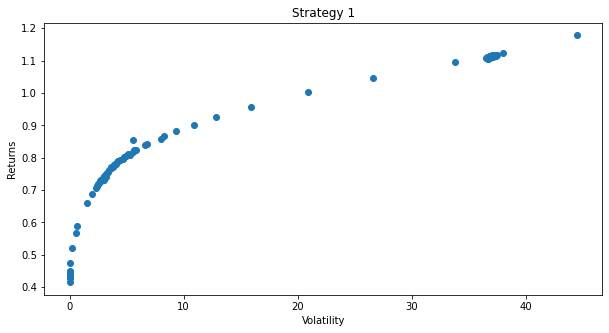

In [92]:
# Strategy 1 Graph of Vol vs Returns with different values of lambda
strat_1_lambda = pd.DataFrame({'lambda': lambda_vals, 'return':return_vals_1, 'volatility': vol_vals_1})
plt.scatter(vol_vals_1, return_vals_1)
plt.title("Strategy 1")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.rcParams["figure.figsize"] = (10,5)

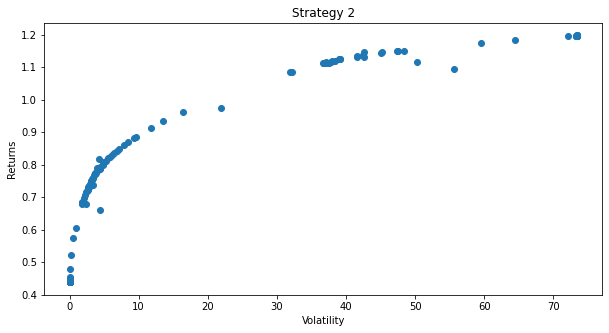

In [88]:
# Strategy 2 Graph of Vol vs Returns with different values of lambda
strat_2_lambda = pd.DataFrame({'lambda': lambda_vals, 'return':return_vals_2, 'volatility': vol_vals_2})
plt.scatter(vol_vals_2, return_vals_2)
plt.title("Strategy 2")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.rcParams["figure.figsize"] = (10,5)

In [126]:
data = pd.DataFrame()

etf_ff_dataDaily = etf_ff_data[['FXE', 'EWJ', 'GLD', 'QQQ', 'SPY', 'SHV', 'DBA', 'USO', 'XBI', 'ILF', 'EPP', 'FEZ']]/252
etf_ff_dataDaily.insert(loc=0, column='Date', value=etf_ff_data['Date'])
print(etf_ff_dataDaily)


# data = pd.DataFrame()
# data['Date'] = etf_ff_data['Date']

# rho, sigma, beta, hist_returns = calculate_params(start = startDate, end = endDate)
        
# _lambda = 0.1
# optimal_strat1 = find_optimal_strategy_1(rho, sigma, beta, _lambda)



           Date       FXE       EWJ       GLD       QQQ       SPY       SHV  \
0    2007-03-01 -0.003333 -0.004743 -0.009928 -0.004615 -0.002980 -0.000028   
1    2007-03-02  0.000682 -0.016337 -0.032057 -0.015071 -0.013095  0.000551   
2    2007-03-05 -0.007575 -0.014533 -0.012243 -0.007768 -0.009519 -0.000184   
3    2007-03-06  0.002672  0.023876  0.019387  0.016607  0.017109  0.000092   
4    2007-03-07  0.004416 -0.002057  0.002338 -0.003967 -0.001002  0.000367   
...         ...       ...       ...       ...       ...       ...       ...   
3942 2022-10-25  0.009441  0.022871  0.002278  0.020686  0.015969  0.000182   
3943 2022-10-26  0.011419  0.005790  0.006364 -0.022096 -0.007534  0.000091   
3944 2022-10-27 -0.010645 -0.012505 -0.001549 -0.018206 -0.005340  0.000182   
3945 2022-10-28 -0.000652  0.010653 -0.010211  0.030601  0.023791 -0.000091   
3946 2022-10-31 -0.007722 -0.005768 -0.008161 -0.011628 -0.007223 -0.000182   

           DBA       USO       XBI       ILF       

In [153]:
startDate = '2007-07-01'
endDate = '2008-03-03'

#LOOKBACKS CANNOT EXCEED 80!!!!!!!!!!!! GOES BEYOND BEGINNING OF DATASET
LB_Cov = 40
LB_Ret = 60

first_index = etf_ff_dataDaily[etf_ff_dataDaily['Date'] >= startDate].index[0]
last_index = etf_ff_dataDaily[etf_ff_dataDaily['Date'] <= endDate].index[-1]

week_indexes = np.arange(first_index, last_index, 5)
#print(etf_ff_dataDaily.iloc[(first_index-80):first_index, :])

cov_lookback_start = etf_ff_dataDaily.iloc[first_index-LB_Cov]['Date']
ret_lookback_start = etf_ff_dataDaily.iloc[first_index-LB_Ret]['Date']
lookback_end = etf_ff_dataDaily.iloc[first_index]['Date']

rho, sigma, beta, hist_returns = calculate_params(start = cov_lookback_start, end = lookback_end)


cov = calculate_params(start = cov_lookback_start, end = lookback_end)[1]
rho = calculate_params(start = ret_lookback_start, end = lookback_end)[0]

print(cov)
print(rho)


          FXE       EWJ       GLD       QQQ       SPY       SHV       DBA  \
FXE  0.042243  0.248189  0.218574  0.381464  0.371369 -0.000593  0.034054   
EWJ  0.248189  1.540626  1.379595  2.214941  2.072250 -0.003775  0.090117   
GLD  0.218574  1.379595  1.254301  1.988472  1.793159 -0.003371  0.056004   
QQQ  0.381464  2.214941  1.988472  3.610544  3.383500 -0.005144  0.367271   
SPY  0.371369  2.072250  1.793159  3.383500  3.410968 -0.004831  0.444907   
SHV -0.000593 -0.003775 -0.003371 -0.005144 -0.004831  0.000010 -0.000072   
DBA  0.034054  0.090117  0.056004  0.367271  0.444907 -0.000072  0.178020   
USO  0.060723  0.310447  0.245722  0.511276  0.597151 -0.000728  0.102622   
XBI  0.548091  3.268158  2.937356  5.094361  4.749515 -0.007743  0.403010   
ILF  0.816707  4.736359  4.121300  7.280918  7.266315 -0.011333  0.723357   
EPP  0.417856  2.410483  2.058287  3.605435  3.738759 -0.005846  0.367776   
FEZ  0.496282  2.783301  2.425861  4.563533  4.538082 -0.006471  0.583106   

In [110]:
# Backtest

def backtest(etf_ff_dataDaily, startDate, endDate, LB_Cov, LB_Ret):
    etf_ff_dataDaily = etf_ff_dataDaily[(etf_ff_dataDaily['Date'] >= startDate) & (etf_ff_dataDaily['Date'] <= endDate)]
    # window = etf_ff_data[0:5]

    dataStrat1 = pd.DataFrame(columns=['Date', 'Return', 'Variance', 'Beta', 'Weight'])
    dataStrat2 = pd.DataFrame(columns=['Date', 'Return', 'Variance', 'Beta', 'Weight'])
    dataStrat1['Date'] = etf_ff_data['Date'][0:LB_Ret]
    dataStrat2['Date'] = etf_ff_data['Date'][0:LB_Ret]

    LB_CovDate = etf_ff_data['Date'][0:LB_Cov]
    LB_RetDate = etf_ff_data['Date'][0:LB_Ret]
    # print(LB_RetDate)

    # Ret = calculate_params(start = startDate, end = LB_RetDate.Date[LB_Ret])

    Sig = calculate_params(start = startDate, end = LB_RetDate[LB_Cov])

    # x = calculate_params(start = startDate, end = etf_ff_data.Date[LB_Cov])
    # print(x)
    


    for i in range(0, LB_Ret):
        rho, sigma, beta, hist_returns = calculate_params(start = startDate, end = etf_ff_dataDaily.Date[i+1])
        # print(hist_returns)
        _lambda = 0.1

        optimal_strat1 = find_optimal_strategy_1(rho, Sig[1], beta, _lambda)
        # Return of Optimal Weights
        dataStrat1['Return'][i+1] = float(rho.T @ optimal_strat1)
        # Variance of Optimal Weights
        dataStrat1['Variance'][i+1] = float(optimal_strat1.T @ sigma @ optimal_strat1)
        # Beta of Optimal Weights
        dataStrat1['Beta'][i+1] = np.dot(beta, optimal_strat1)
        dataStrat1['Weight'][i+1] = optimal_strat1

        # print(dataStrat1)

        optimal_strat2 = find_optimal_strategy_2(rho, Sig[1], beta, _lambda)
        # Return of Optimal Weights
        # print(float(rho.T @ optimal_strat2))
        dataStrat2['Return'][i+1] = float(rho.T @ optimal_strat2)
        # Variance of Optimal Weights
        # print(float(optimal_strat2.T @ sigma @ optimal_strat2)) 
        dataStrat2['Variance'][i+1] = float(optimal_strat2.T @ sigma @ optimal_strat2)
        # Beta of Optimal Weights
        # print(np.dot(beta, optimal_strat2))
        dataStrat2['Beta'][i+1] = np.dot(beta, optimal_strat2)
        dataStrat2['Weight'][i+1] = optimal_strat2

    # print(dataStrat1)
    # print(dataStrat2)
    return (dataStrat1, dataStrat2)


backtest1, backtest2 = backtest(etf_ff_dataDaily, '2007-03-01', '2007-11-28', 40, 90) #Before Subcrisis

<ipython-input-110-8a68f8b6adc3>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataStrat1['Return'][i+1] = float(rho.T @ optimal_strat1)
<ipython-input-110-8a68f8b6adc3>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataStrat1['Variance'][i+1] = float(optimal_strat1.T @ sigma @ optimal_strat1)
<ipython-input-110-8a68f8b6adc3>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataStrat1['Beta'][i+1] = np.dot(beta, optimal_strat1

In [ ]:
weights1_180_40, weights2_180_40 = backtest(etf_ff_dataDaily, '2007-03-01', '2007-11-28', 40, 180) #Before Subcrisis
x=0